In [1]:
# change to parent directory to import module
%cd ..

/home/achilleas/projects/osbuild/metrics


In [2]:
# imports, function definitions, and global settings
import json
import pandas
import report

import numpy as np
import matplotlib.pyplot as plt
import ibmetrics as ib

from datetime import datetime, timedelta

from IPython.display import display, Markdown


def mdprint(msg):
    display(Markdown(msg))

In [3]:
# read data
builds = report.read_file("./data/dump-2022-11-28.log")
users = pandas.read_json("./data/userinfo.json", dtype=False)
with open("./data/userfilter.txt", encoding="utf-8") as filterfile:
    user_filter = filterfile.read().split("\n")

mdprint(f"Read {len(builds)} records")

Using cached pickle file at /home/achilleas/.cache/osbuild-metrics/dump-2022-11-28.pkl


Read 7662 records

In [4]:
# filtering: remove builds before GA
ga_date = datetime(2022, 5, 4)
ga_idxs = builds["created_at"] >= ga_date
builds = builds.loc[ga_idxs]
mdprint(f"Using {len(builds)} records (since GA)")

# filtering: remove internal users
builds = ib.data.filter_users(builds, users, user_filter)
mdprint(f"Using {len(builds)} records (after filtering)")

Using 5828 records (since GA)

Using 2348 records (after filtering)

In [5]:
summary = ib.metrics.make_summary(builds)
mdprint(ib.metrics.summarise(summary))

Summary
=======

Period: 2022-05-04 14:11:47.137615 - 2022-11-26 15:24:35.976192

- Total builds: 2348
- Number of users: 861
- Builds with packages: 1364
- Builds with filesystem customizations: 816
- Builds with custom repos: 47

Text(0.5, 1.0, 'Footprints')

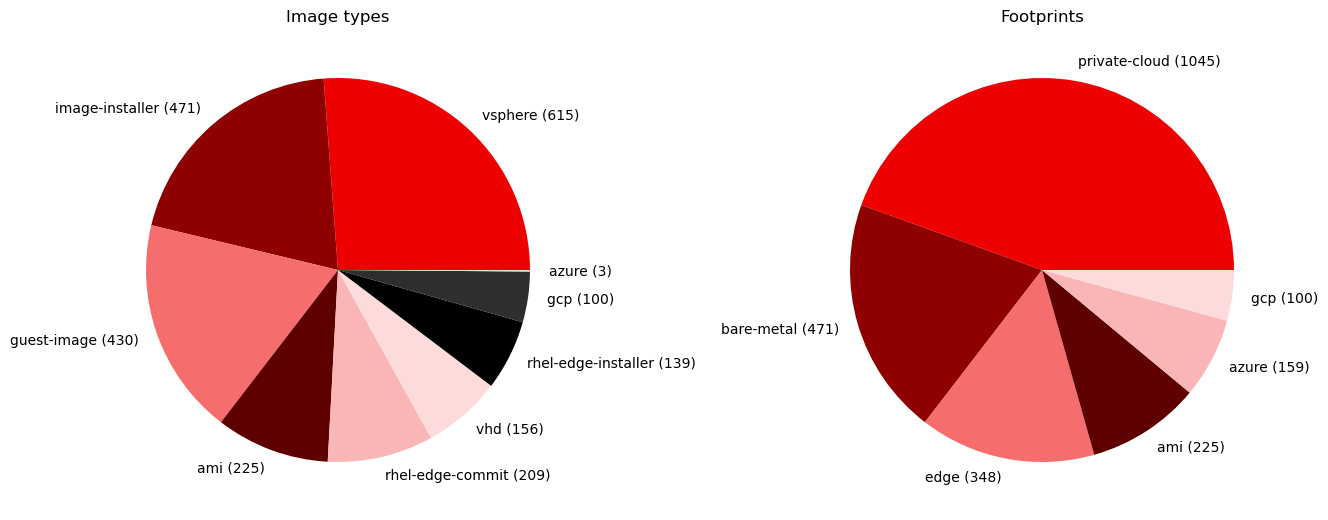

In [6]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1])
ib.plot.imagetype_builds(builds, ax1)
ax1.set_title("Image types")

ax2 = fig.add_axes([1.1, 0, 1, 1])
ib.plot.footprint_builds(builds, ax2)
ax2.set_title("Footprints")

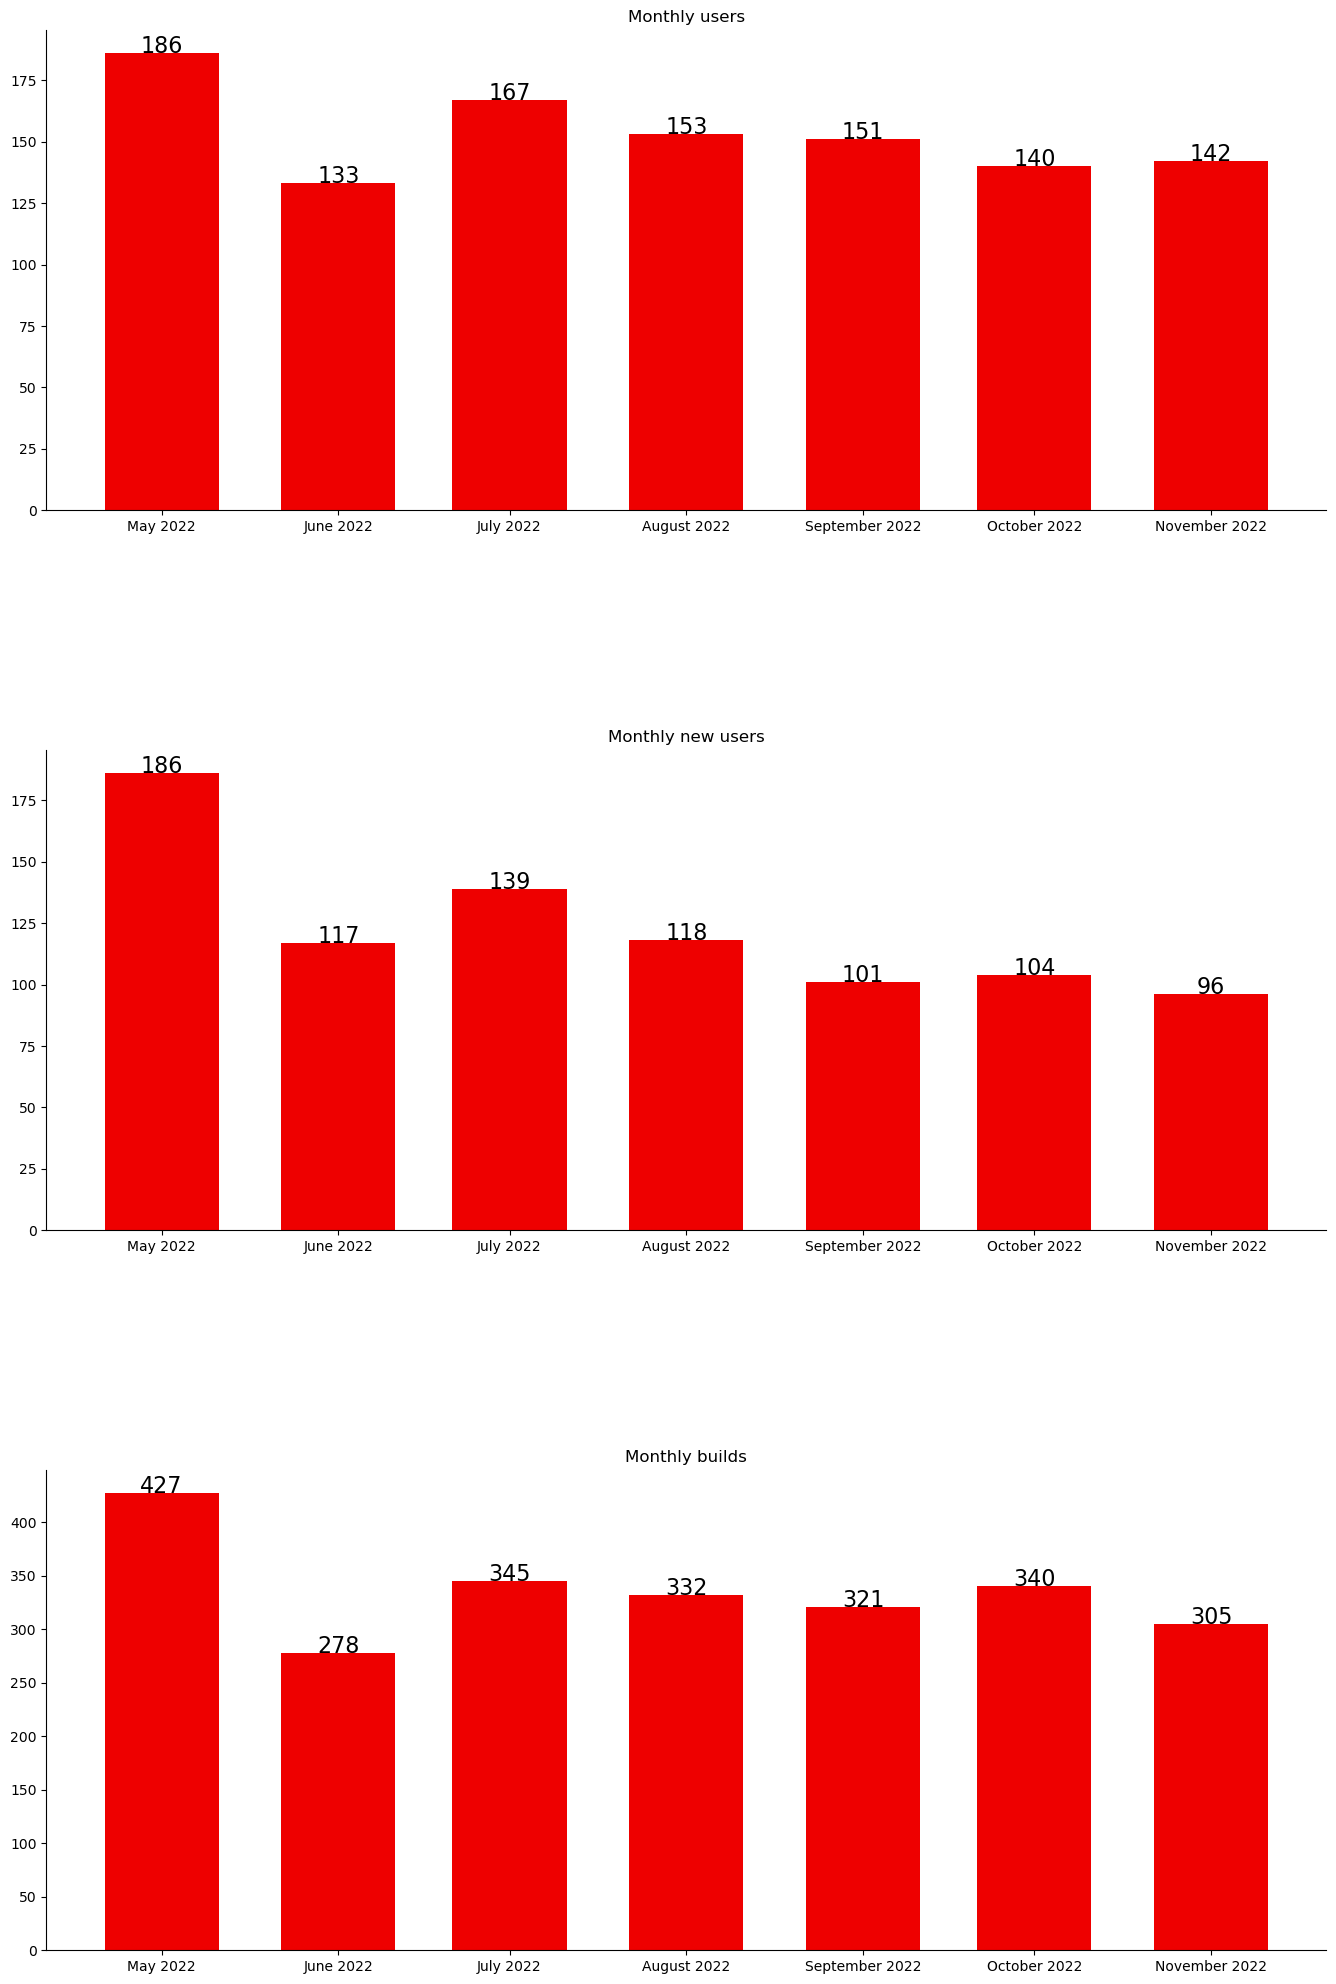

In [7]:
# draw bar graphs again on one figure for convenience
fig = plt.figure()
users_ax = fig.add_axes([0, 3, 2, 1])
ib.plot.monthly_users(builds, users_ax)

new_users_ax = fig.add_axes([0, 1.5, 2, 1])
ib.plot.monthly_new_users(builds, new_users_ax)

builds_ax = fig.add_axes([0, 0, 2, 1])
ib.plot.monthly_builds(builds, builds_ax)

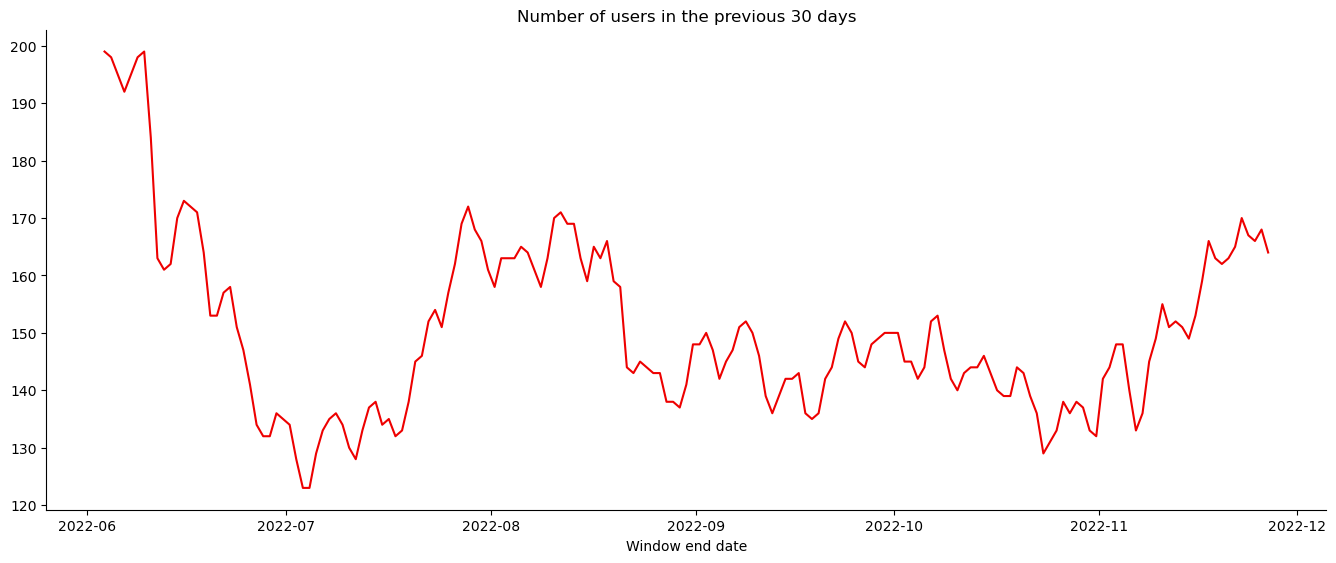

In [8]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 1])
ib.plot.users_sliding_window(builds, ax)

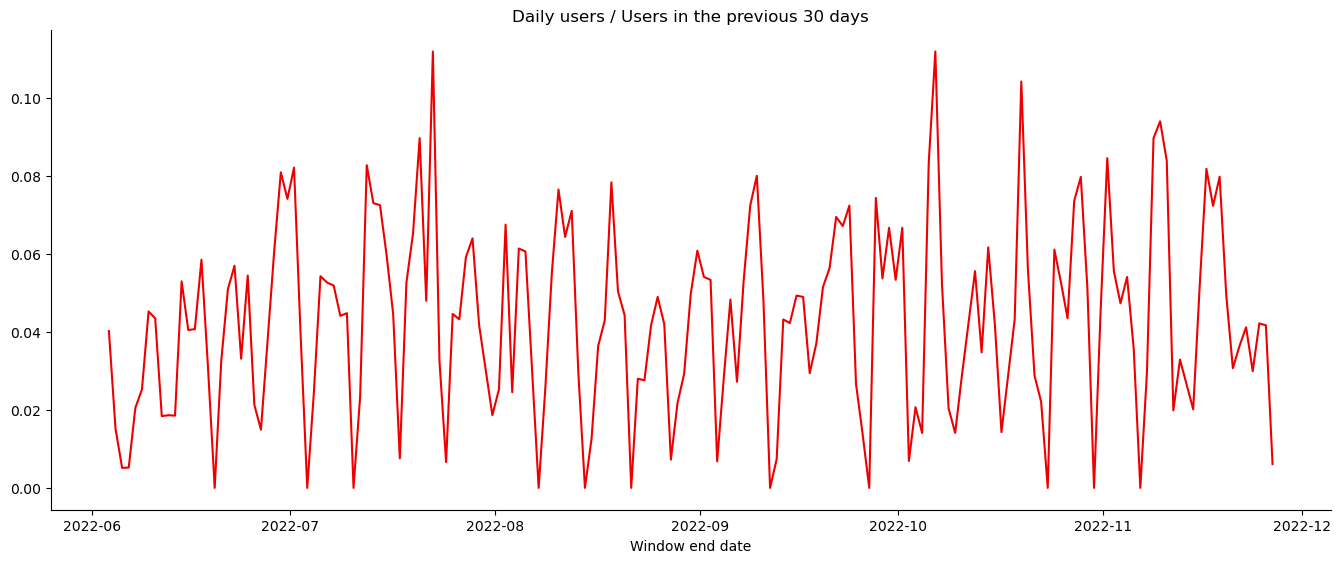

In [9]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 1])
ib.plot.dau_over_mau(builds, ax)

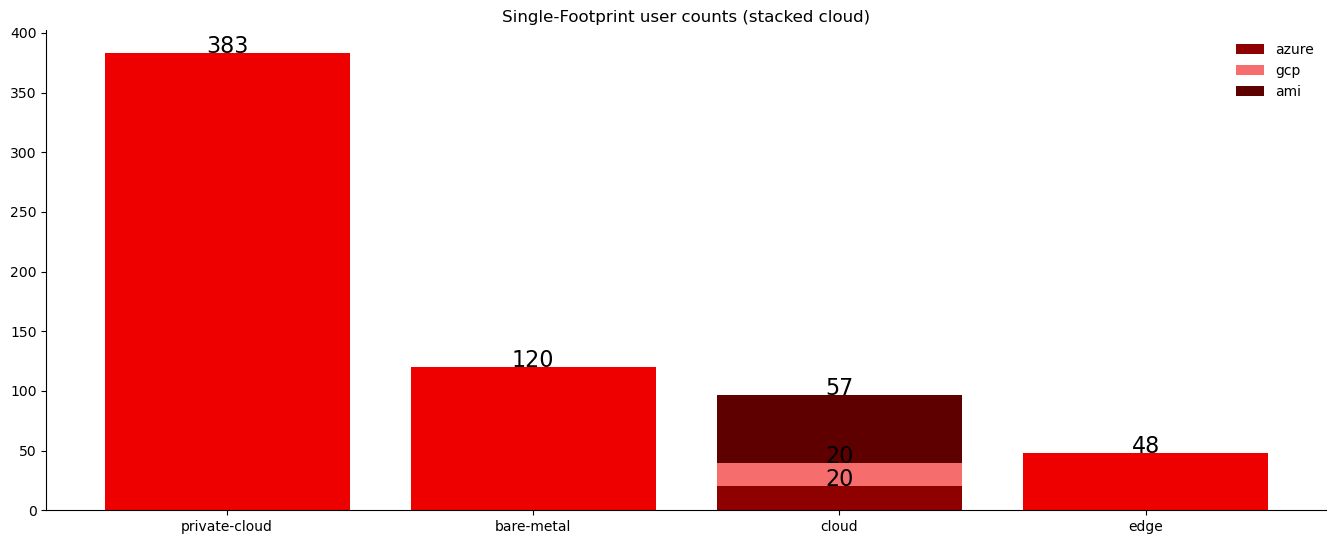

In [10]:
# distribution of single-footprint users (stacked cloud)
# it's a little hacky, but that's okay for this notebook
fig = plt.figure()
ax = plt.axes([0, 0, 2, 1])

sfp_users = ib.metrics.single_footprint_users(builds)
fp_counts = sfp_users["footprint"].value_counts()
# ax.bar(fp_counts.index, fp_counts.values)

bottom = 0
clouds = {"ami", "azure", "gcp"}
cloud_sum = sum(v if k in clouds else 0 for k, v in fp_counts.items())

cloud_grouped_feet = fp_counts.copy()
cloud_grouped_feet["cloud"] = cloud_sum
for cloud in clouds:
    del cloud_grouped_feet[cloud]

cloud_grouped_feet.sort_values(ascending=False, inplace=True)
ax.bar(cloud_grouped_feet.index, cloud_grouped_feet.values)  # plot with grouped cloud to get them in order (sorted)
for ft in cloud_grouped_feet.items():
    if ft[0] == "cloud":
        continue
    ax.text(ft[0], ft[1], str(ft[1]), size=16, ha="center")

# # draw over cloud bar with breakdown values of individual clouds
for cld in clouds:
    ax.bar("cloud", fp_counts[cld], bottom=bottom, label=cld)  
    ax.text("cloud", fp_counts[cld]+bottom, str(fp_counts[cld]), size=16, ha="center")
    bottom += fp_counts[cld]

ax.set_title("Single-Footprint user counts (stacked cloud)")
ax.legend()

In [11]:
# separate builds for "edge" types
edge_idxs = builds["image_type"].str.contains("edge")
edge_builds = builds.loc[edge_idxs]
non_edge_builds = builds.loc[-edge_idxs]

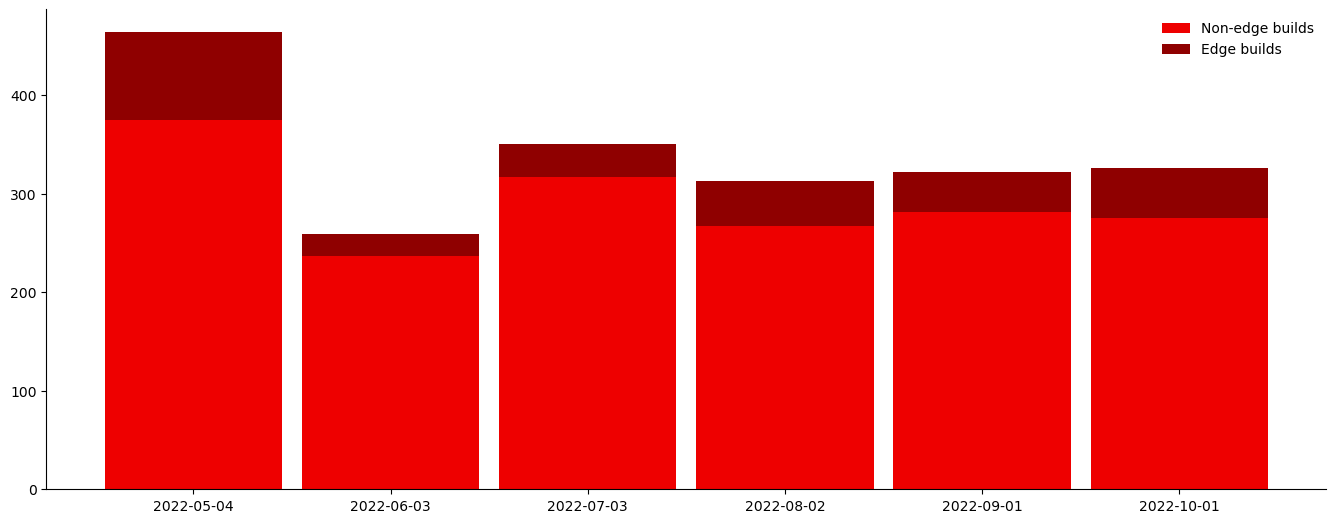

In [12]:
# builds per 7-day period for edge vs non-edge
plt.figure()
ax = plt.axes([0, 0, 2, 1])
width=30
p_days = timedelta(days=width)

e_starts, eb = ib.metrics.builds_over_time(edge_builds, p_days)
ne_starts, ne = ib.metrics.builds_over_time(non_edge_builds, p_days)

ax.bar(ne_starts, ne, width=width*.9, label="Non-edge builds")
ax.bar(ne_starts, eb, bottom=ne, width=width*.9, label="Edge builds")
ax.set_xticks(ne_starts)

ax.legend()

In [13]:
# Separate *users* based on edge vs non-edge
# If any user builds at least one edge image, put all their builds in the edge bucket
edge_users = edge_builds["org_id"].unique()
all_users = builds["org_id"].unique()
non_edge_users = np.setdiff1d(all_users, edge_users)
print(f"Number of edge users*:    {len(edge_users):4d}")
print(f"Number of non-edge users: {len(non_edge_users):4d}")
print(f"Total users:              {len(all_users):4d}")
print('(* "edge user" is any user that has ever built at least a single edge image)')

assert len(edge_users) + len(non_edge_users) == len(all_users)

Number of edge users*:      76
Number of non-edge users:  785
Total users:               861
(* "edge user" is any user that has ever built at least a single edge image)


In [14]:
# Separate builds based on edge-tagged users
edge_user_builds_idxs = builds["org_id"].isin(edge_users)
edge_user_builds = builds.loc[edge_user_builds_idxs]
non_edge_user_builds_idxs = builds["org_id"].isin(non_edge_users)
non_edge_user_builds = builds.loc[non_edge_user_builds_idxs]

print(f"Number of builds from edge users*:    {len(edge_user_builds):4d}")
print(f"Number of builds from non-edge users: {len(non_edge_user_builds):4d}")
print(f"Total builds:                         {len(builds):4d}")
print('(* "edge user" is any user that has ever built at least a single edge image)')

assert len(edge_user_builds) + len(non_edge_user_builds) == len(builds)

Number of builds from edge users*:     460
Number of builds from non-edge users: 1888
Total builds:                         2348
(* "edge user" is any user that has ever built at least a single edge image)


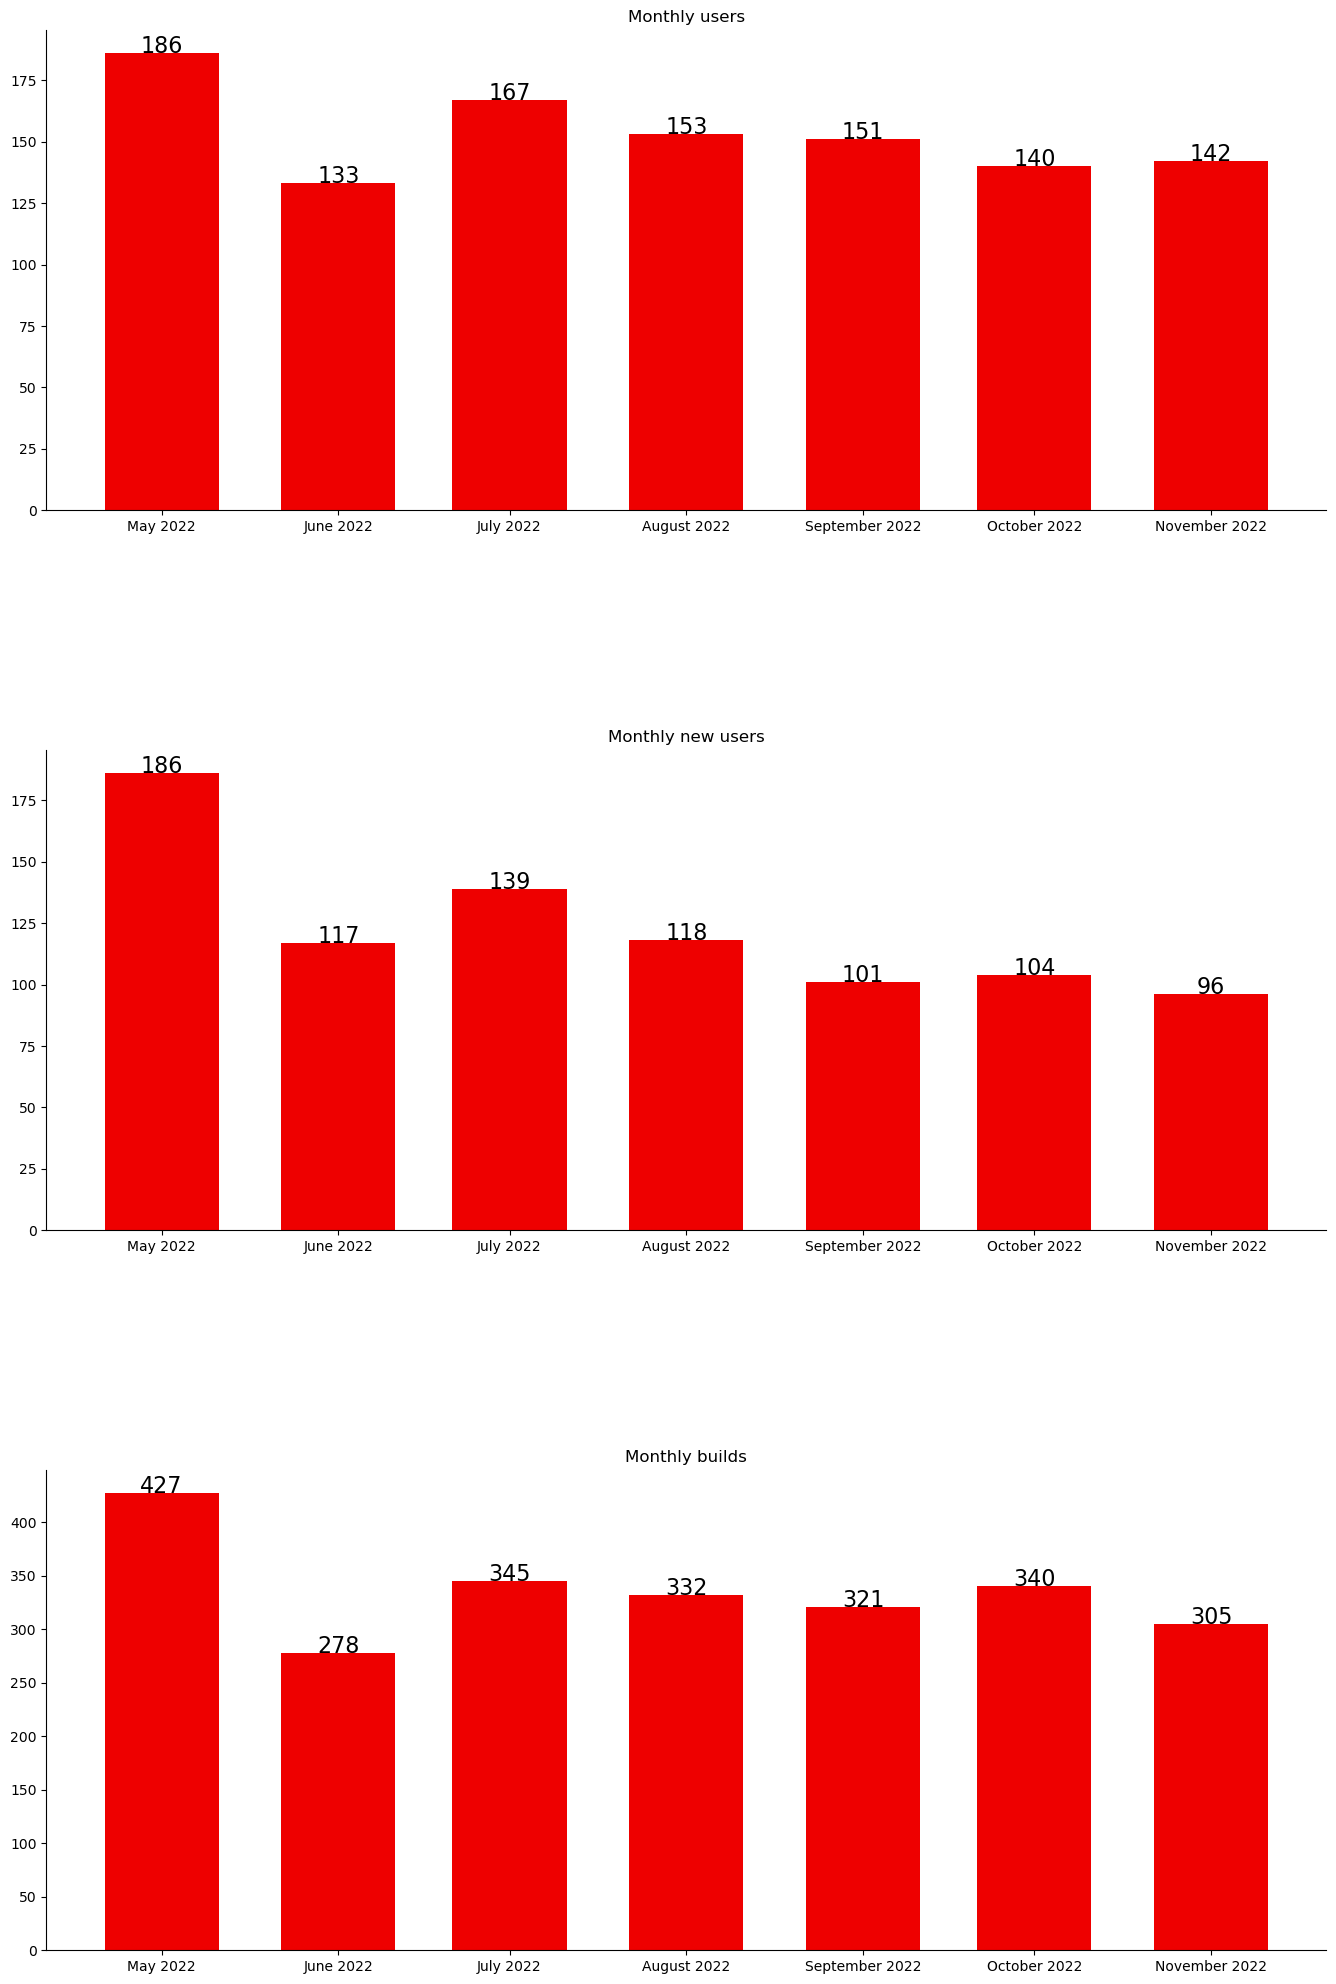

In [15]:
# draw bar graphs again on one figure for convenience
fig = plt.figure()
users_ax = fig.add_axes([0, 3, 2, 1])
ib.plot.monthly_users(builds, users_ax)

new_users_ax = fig.add_axes([0, 1.5, 2, 1])
ib.plot.monthly_new_users(builds, new_users_ax)

builds_ax = fig.add_axes([0, 0, 2, 1])
ib.plot.monthly_builds(builds, builds_ax)